# Applied Deep Learning Final Project
## Movie Genre Classification
-------------------------------
**Integrante 1**: Ricardo Medina Aponte...........................................................  **Código**: 200520707

**Integrante 2**: Andrea Carolina Parra López...................................................**Código**: 201727740



#Model with a Machine Learning algorithm.
## ## Load and Process Data.
With the next code, we can access to the google Drive account. 

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Read data with api Kaggle.
We download the kaggle credentials to Colab and start using Kaggle API to read data.

In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!pip install kaggle

    100% |████████████████████████████████| 51kB 2.0MB/s 
    100% |████████████████████████████████| 51kB 7.1MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /content/.cache/pip/wheels/3b/8e/14/adcbb71d126f5fb939fec8aa81394450922c20eee876bf8882
Successfully built kaggle
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
!kaggle competitions list

ref                                              deadline             category            reward  teamCount  userHasEntered  
-----------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
house-prices-advanced-regression-techniques      2030-01-01 00:00:00  Getting Started  Knowledge       4811           False  
digit-recognizer                                 2030-01-01 00:00:00  Getting Started  Knowledge       2636           False  
titanic                                          2030-01-01 00:00:00  Getting Started  Knowledge      10604           False  
imagenet-object-localization-challenge           2029-12-31 07:00:00  Research         Knowledge         20           False  
competitive-data-science-predict-future-sales    2019-01-01 23:59:00  Playground           Kudos       1012           False  
tgs-salt-identification-challenge                2018-10-19 23:59:00  Featured          $100,000        277           

The following codes allow to download the different data included in the competition. There are four files, two in CSV and two in Zip format.


In [0]:
!kaggle competitions download -c miia4406-movie-genre-classification -f images_resize_gray.zip -p DL/data

 78%|██████████████████████████████▍        | 87.0M/112M [00:00<00:00, 93.7MB/s]
100%|█████████████████████████████████████████| 112M/112M [00:00<00:00, 151MB/s]


In [0]:
!kaggle competitions download -c miia4406-movie-genre-classification -f dataTesting.csv -p DL/data
!kaggle competitions download -c miia4406-movie-genre-classification -f dataTraining.csv -p DL/data

  0%|                                               | 0.00/2.51M [00:00<?, ?B/s]
100%|███████████████████████████████████████| 2.51M/2.51M [00:00<00:00, 119MB/s]
  0%|                                               | 0.00/6.13M [00:00<?, ?B/s]
100%|██████████████████████████████████████| 6.13M/6.13M [00:00<00:00, 64.8MB/s]


In [0]:
!ls DL/data

dataTesting.csv  dataTraining.csv  images_resize_gray.zip


In [0]:
!cd DL/data && unzip images_resize_gray.zip

## Text classification with Random Forest

In the text classification we have two kind of data in CSV format. These files contain the following variables of the films: genre, title, rating, description of the film, year and an ID to relate the movie with the file images. 

In [0]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [0]:
path = 'DL'

load the movies files

In [0]:
dataTraining = pd.read_csv(os.path.join(path, 'data', 'dataTraining.csv'), encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv(os.path.join(path, 'data', 'dataTesting.csv'), encoding='UTF-8', index_col=0)

In [0]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [0]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


After analyzing the data, we find some variables with an unstructred text, for this reason we use Tokenization, to give structure to the information. 

Before selecting the characteristics presented below, several models were evaluated with different aspects.

* **Max Features**: to select the appropriate number of words used with frequency in the text, the model was tested with 10.000, 20.000, 30.000, 40.000 and 50.000 words
* **Lower cases** : We tested the model with *lowercases=False*
* **N-grams**: in n-grams we tested with parameters 2, 3, and without n-grams
* **Stopwords**: the model was tested including stopwords and excluding these kind of words.
* **Stemming**: In the class about text analysis with SAS, we observed many words searched by its root, this exercise helped us to evaluate the inclusion of stemming in the model




The features use for the final model were: n-grams=2, max_features=30.000, include stemming and the lowercase false.


In [0]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
def split_into_lemmas(text):
    text = text.lower()
    words = text.split()
    return [stemmer.stem(word) for word in words]
vect = CountVectorizer(ngram_range=(1, 2),analyzer=split_into_lemmas, lowercase=False, max_features=30000)
X_dtm = vect.fit_transform(dataTraining['plot'])
X_dtm.shape

(7895, 26934)

Some words include in the data

In [0]:
print(vect.get_feature_names()[50:100])

['aberr', 'abet', 'abhor', 'abhorr', 'abid', 'abigail', 'abil', 'abilen', 'abin', 'abit', 'abkani', 'abl', 'ablixa', 'abm', 'abn', 'abner', 'abney', 'abnorm', 'aboard', 'abod', 'abolish', 'abolit', 'abolitionist', 'abomin', 'aborigin', 'abort', 'abound', 'about', 'abov', 'abra', 'abraham', 'abram', 'abramoff', 'abras', 'abrasax', 'abroad', 'abronsius', 'abrupt', 'abscond', 'absenc', 'absent', 'absente', 'absentia', 'abshir', 'absolut', 'absolv', 'absorb', 'absorpt', 'abstin', 'abstract']


In [0]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

The training data base was divided in training and test in proportions of  0.7 and 0.3.
The Random Forest model was tested with the n_estimators and max_deph.
* **n_estimators**: The amount of trees determinded for the Random Forest model was 5000. However, it was tested previously with 4.000, 3.000, 2.000, 1.000 and 6.000 trees.
* **max_deph**: For the depth of the trees the values ​​5, 10, 15, 20 were taken into account, finally 15 was the selected valued.

In [0]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.30, random_state=42)

In [0]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=5000, max_depth=15, random_state=42))

In [0]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          n_jobs=1)

In [0]:
y_pred_genres = clf.predict_proba(X_test)

Some results of models tested
<br>
<table>
<tr>
<th>$Features$</th>
<th>$AUC$</th>
</tr>
<tr>
<td> max_features=20000</td>
<td style="text-align:center">0.78863</td>
<td ></td>
</tr>
<tr>
<td>max_features=30000</td>
<td style="text-align:center">0.80268</td>
</tr>
<tr>
<td>max_features=30000 and n_estimators: 300</td>
<td style="text-align:center">0.81938</td>
</tr>
<tr>
<td>max_features=30000, n_estimators: 300, max_depth=20</td>
<td style="text-align:center">0.81717</td>
</tr>
 <tr>
<td>max_features=30000, n_estimators: 400, max_depth=20</td>
<td style="text-align:center">0.81957</td>
</tr>
 <tr>
<td>max_features=40000, n_estimators: 500,stemmer, n-grams=2 max_depth=20</td>
<td style="text-align:center">0.83537</td>
</tr>
</table>



In [0]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8409549939503472

## Training with all data
After validating the model with the "test", it was training with all the data base, and its results was submit in kaggle


In [0]:
clf2 = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=5000, max_depth=15, random_state=42))
clf2.fit(X_dtm, y_genres)
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = clf.predict_proba(X_test_dtm)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_text_RF_5.csv', index_label='ID')

In [0]:
from google.colab import files
files.download('pred_genres_text_RF_5.csv')

In [0]:
!kaggle competitions submit -c miia4406-movie-genre-classification -f pred_genres_text_RF_5.csv -m "text_3_md4"

Successfully submitted to MIIA4406 - MOVIE GENRE CLASSIFICATION

##Image classification with Random Forest

For the first excercise we use the gray images to test a Random Forest model.



In [0]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skimage import io
import os
%matplotlib inline

In the work directory we upload  the gray images to beging the project

In [0]:
!ls DL/data

dataTesting.csv  dataTraining.csv  images_resize_gray  images_resize_gray.zip


In [0]:
path = 'DL/data'

In [0]:
dataTraining = pd.read_csv(os.path.join(path, 'dataTraining.csv'), encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv(os.path.join(path, 'dataTesting.csv'), encoding='UTF-8', index_col=0)

## Read Gray Images
The next codes permit the  images visualization 

In [0]:
import skimage
image1 = skimage.io.imread(os.path.join(path, 'images_resize_gray', str(dataTraining.index[0]) + '_resize_gray.jpeg'))
image2 = skimage.io.imread(os.path.join(path, 'images_resize_gray', str(dataTraining.index[3]) + '_resize_gray.jpeg'))
image3 = skimage.io.imread(os.path.join(path, 'images_resize_gray', str(dataTraining.index[100]) + '_resize_gray.jpeg'))

In [0]:
image1.shape, image2.shape, image3.shape

((256, 160), (256, 160), (256, 160))

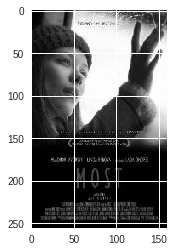

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(image1, cmap='gray')


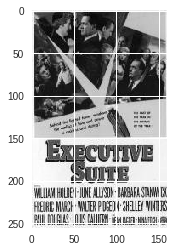

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(image2, cmap='gray')


In [0]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(image3, cmap='gray')

Now we read all images

In [0]:
from tqdm import tqdm
images_training=[]
for i in tqdm(dataTraining.index):
    images_training.append(skimage.io.imread(os.path.join(path, 'images_resize_gray', str(i) + '_resize_gray.jpeg')).flatten())

100%|██████████| 7895/7895 [00:05<00:00, 1572.47it/s]


In [0]:
images_training = np.stack(images_training)

images_training.shape, dataTraining.shape[0]

((7895, 40960), 7895)

In [0]:
images_testing = []
for i in tqdm(dataTesting.index):
    images_testing.append(skimage.io.imread(os.path.join(path, 'images_resize_gray', str(i) + '_resize_gray.jpeg')).flatten())

images_testing = np.stack(images_testing)

images_testing.shape, dataTesting.shape[0]

100%|██████████| 3383/3383 [00:01<00:00, 1693.94it/s]


((3383, 40960), 3383)

## Apply PCA

The images were transformed with principal components analysis PCA in the test and training data.
We tested PCA with different components.
<br>
<table>
<tr>
<th>$components$</th>
<th>$Variance explained$</th>
</tr>
<tr>
<td> 10</td>
<td style="text-align:center">0.5488</td>
<td ></td>
</tr>
<tr>
<td>20</td>
<td style="text-align:center">0.6105</td>
</tr>
<tr>
<td>25</td>
<td style="text-align:center">0.6301</td>
</tr>
<tr>
<td>100</td>
<td style="text-align:center">0.7416</td>
</tr>
 <tr>
<td>200</td>
<td style="text-align:center">0.7897</td>
</tr>
 <tr>
<td>300</td>
<td style="text-align:center">0.8169</td>
</tr>
</table>

In this case we tuned up the PCA using an explained variance of 63%, we took 25 variables.

In [0]:
pca = PCA(n_components=25)
images_training_pca = pca.fit_transform(images_training)


In [0]:
sum(pca.explained_variance_ratio_)

0.6301178947868343

In [0]:
images_testing_pca = pca.transform(images_testing)

## Create Y
The trainig data images were divided in training and test with  0.7, 0.3 proportions.

In [0]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [0]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(images_training_pca, y_genres, test_size=0.30, random_state=50)

In [0]:
y_genres 


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

## Training multi-class multi-label model
* **n_estimators**: The amount of trees used for the Random Forest model were 5000. Previously was tested with 1500, 500, 100, 1.000 and 6.000 trees.
* **max_deph**: For the depth of the trees the values ​​5, 10, 15, 20 were taken into account. After analyzing the resaults 15 was the selected value

In [0]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=1500, max_depth=15, random_state=50))

In [0]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1500, n_jobs=-1,
            oob_score=False, random_state=50, verbose=0, warm_start=False),
          n_jobs=1)

In [0]:
y_pred_genres1 = clf.predict_proba(X_test)

This model present an AUC with values under 0.6. These values are lower than those we obtained with the Random Forest model of the text data.
Results :
<br>
<table>
<tr>
<th>$features$</th>
<th>$AUC$</th>
</tr>
<tr>
<td> components=200, n_estimators: 1500, max_depth=15</td>
<td style="text-align:center">0.54910</td>
<td ></td>
</tr>
<tr>
<td>components=300, n_estimators: 500, max_depth=15</td>
<td style="text-align:center">0.54261</td>
</tr>
<tr>
<td>components=200, n_estimators: 500, max_depth=10</td>
<td style="text-align:center">0.55891</td>
</tr>
<tr>
<td>components=300, n_estimators: 2000, max_depth=10</td>
<td style="text-align:center">0.50008</td>
</tr>
</table>

In [0]:
roc_auc_score(y_test_genres, y_pred_genres1, average='macro')

0.5802260826536205

## Apply models to test



In [0]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres1 = clf.predict_proba(images_testing_pca)

To link both models, we used a maximum likelihood criteria between values.

In [0]:
pd.DataFrame(y_pred_test_genres1, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_RF1.csv', index_label='ID')

In [0]:
from google.colab import files
files.download('pred_genres_img_RF1.csv')

In [0]:
!kaggle competitions submit -c miia4406-movie-genre-classification -f pred_genres_img_RF1.csv -m "text_3_md4"

Successfully submitted to MIIA4406 - MOVIE GENRE CLASSIFICATION

## Merged text and images model
To merge the maximum likelihood criteria between the best sparately trained models was used.


In [0]:
y_pred_test_genres1.shape,y_pred_test_genres.shape


((3383, 24), (3383, 24))

In [0]:
y_pred_test_genres2=y_pred_test_genres
for i in range(3383):
  for j in range(24):
    y_pred_test_genres2[i][j]=max(y_pred_test_genres1[i][j],y_pred_test_genres[i][j])


y_pred_test_genres2[1]

array([0.14618898, 0.09940688, 0.02553197, 0.04088071, 0.34820087,
       0.19937039, 0.07928273, 0.49044115, 0.06913041, 0.10251603,
       0.01371479, 0.02771752, 0.43695182, 0.03084691, 0.02478332,
       0.16716393, 0.01181107, 0.16248835, 0.07864753, 0.00995831,
       0.02157711, 0.4913058 , 0.03207433, 0.01898275])

In [0]:
y_pred_test_genres1[1][1]

0.06250262668505581

In [0]:
pd.DataFrame(y_pred_test_genres2, index=dataTesting.index, columns=cols).to_csv('pred_genres_comb.csv', index_label='ID')

In [0]:
from google.colab import files
files.download('pred_genres_comb.csv')

In [0]:
!kaggle competitions submit -c miia4406-movie-genre-classification -f pred_genres_comb.csv -m "text_3_md4"

Successfully submitted to MIIA4406 - MOVIE GENRE CLASSIFICATION

#Model with a Deep Learning algorithm.

To develop the second model, we used Transfer Learning

In [0]:
##!kill -9 -1
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13154342813668217807, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11285974221
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12238196443248421398
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

##Loading libraries and color images

The following code is used to load the libraries and present the basic information of the data

In [0]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm
import os
%matplotlib inline

there are 2 datasets, training and testing description ***Genres*** is the objective variable

In [0]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


the testing database 

In [0]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


## Read Color Images

This code allowed us to observe color images.

In [0]:
#Loading some movies images
image = io.imread(os.path.join(path, 'data', 'images', str(dataTraining.index[0]) + '.jpeg'))
print(image.shape)
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(image)

Most of movies have several clasifications

In [0]:
# image = io.imread(os.path.join(path, 'data', 'images', str(dataTraining.index[0]) + '.jpeg'))
nb_classes = range(0,20)

# Plot 20 images
fig, ax = plt.subplots(4,5, figsize=(15,15))
ax = ax.reshape(20)
for i in nb_classes:
    image = io.imread(os.path.join(path, 'data', 'images', str(dataTraining.index[i]) + '.jpeg'))
    ax[i].imshow(image)
    ax[i].set_title(str(dataTraining.iloc[i,3]))
    ax[i].axis('off')

ax[-1].axis('off')
ax[-2].axis('off')
plt.show()

Because we have 10.000 images, it is necessary to load them in batches; then, we separate them by training and test images in different folders

In [0]:
!cd DL/data && mkdir img
!cd DL/data/img && mkdir test
!cd DL/data/images && mkdir train

In [0]:
!ls DL/data

dataTesting.csv  dataTraining.csv  images  img


In [0]:
#MOVING THE TEST IMAGES TO 'DL/data/img/test'
#MOVING THE TRAIN IMAGES TO  'DL/data/imgages/train'
#THERE ARE 7895 TRAIN IMAGES AND 3383 TEST IMAGES
import pandas as pd
import os
import numpy as np
import shutil


tpath = 'DL/data/images/train'
tindx = list(dataTraining.index)

print('train: ',len(tindx))

current_img = ''

for f in tindx:

  current_img = str('DL/data/images/' + str(f) + '.jpeg')
  ##**Check this Line Accordingly** 
  shutil.move(current_img, tpath)
  
tpath = 'DL/data/img/test'
tindx = list(dataTesting.index)  
current_img = ''
print('test: ',len(tindx))
for g in tindx:

  current_img = str('DL/data/images/' + str(g) + '.jpeg')
  ##**Check this Line Accordingly** 
  shutil.move(current_img, tpath)

train:  7895
test:  3383


## Transfer learninig.

Load the pre - trained VGG16 model without the top layers, this is just for images convolution

In [0]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

model = VGG16(weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
!pip3 install image
!pip3 install pyautogui

##Images convolution with training folder for training and test.

System parameter to allow loading large size images

In [0]:
import sys
from PIL import Image
sys.modules['Image'] = Image
Image.MAX_IMAGE_PIXELS = 900000000

The training images were divided in training and test, with flow_from_directory. Then we create the dictionary to convolutionate them in batches and resize it to 224X224 pixeles

In [0]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications


img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'DL/data/images'
validation_data_dir = 'DL/data/img'
nb_train_samples = 7895
nb_validation_samples = 3383
batch_size = 64


data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_generator.flow_from_directory(train_data_dir, target_size=(img_width, img_height), shuffle=False, seed=13,
                                                     class_mode=None, batch_size=batch_size, subset="training")

validation_generator = data_generator.flow_from_directory(train_data_dir, target_size=(img_width, img_height),  shuffle=False, seed=13,
                                                     class_mode=None, batch_size=batch_size, subset="validation")

Using TensorFlow backend.


Found 6316 images belonging to 1 classes.
Found 1579 images belonging to 1 classes.


In [0]:
#save the image file path (this is for get the INDEX images)
files_train = train_generator.filenames
files_test = validation_generator.filenames

In [0]:
files_train[:5]

['train/1915.jpeg',
 'train/1916.jpeg',
 'train/1918.jpeg',
 'train/1919.jpeg',
 'train/192.jpeg']

get the index from path images


In [0]:
files_train = [w.replace('train/', '') for w in files_train]
files_train = [w.replace('.jpeg', '') for w in files_train]

files_test = [w.replace('train/', '') for w in files_test]
files_test = [w.replace('.jpeg', '') for w in files_test]

then we have the index images, to relate the description and genres


In [0]:
files_train[:5]

['1915', '1916', '1918', '1919', '192']

We get the information related to each image in the order of flow_from_directory load


In [0]:
y_train = pd.DataFrame()
y_test = pd.DataFrame()

for i in files_train:
  y_train = y_train.append(dataTraining.loc[int(i)])

for i in files_test:
  y_test = y_test.append(dataTraining.loc[int(i)])
  
y_train.head()


,genres,plot,rating,title,year
1915,"['Crime', 'Drama', 'Thriller']","cosmo vitelli owns the crazy horse west , a s...",7.5,The Killing of a Chinese Bookie,1976.0
1916,['Short'],the sound has been found in the form of an old...,6.8,Dickson Experimental Sound Film,1894.0
1918,"['Documentary', 'Crime']",set in N on the inner - city streets of oakl...,6.7,Cocaine Cowboys 2,2008.0
1919,"['Drama', 'Music', 'Romance']","honey daniels is a N - year - old , sexy , ...",5.3,Honey,2003.0
192,"['Action', 'Comedy', 'Fantasy']","an ancient scroll that , when recited out lou...",5.5,Bulletproof Monk,2003.0


In [0]:
print(y_test.shape)
y_test.head()

(1579, 5)


,genres,plot,rating,title,year
0,"['Adventure', 'Comedy', 'Family']",major benson winifred payne is being discharge...,6.1,Major Payne,1995.0
10,"['Drama', 'History']","in N th - century china , seven year old gir...",6.1,Snow Flower and the Secret Fan,2011.0
100,"['Drama', 'Mystery', 'Thriller']","in N new orleans , dr . john cukrowicz , ...",7.7,"Suddenly, Last Summer",1959.0
10000,"['Comedy', 'Crime', 'Drama', 'Sci-Fi']","in the near future , frank is a retired catbu...",7.1,Robot & Frank,2012.0
10001,['Comedy'],"in los angeles , a depressed writer named sol...",6.4,The Dog Problem,2006.0


The following codes were used for save images convolutinated for test and training, the shape necesary for merge with VGG16 pre-trained was (7,7,512)

In [0]:
#getting convolutionated the images (TRAIN) 
bottleneck_features_train = model.predict_generator(train_generator)

In [0]:
#We convulationated train images to 7,7,512
bottleneck_features_train.shape

(6316, 7, 7, 512)

In [0]:
#getting convolutionated the images (TEST)
bottleneck_features_validation = model.predict_generator(validation_generator)

In [0]:
#We convulationated test images to 7,7,512
bottleneck_features_validation.shape

(1579, 7, 7, 512)

In [0]:
#Building the response data in One Hot Encode Sequence
le = MultiLabelBinarizer()
y_train_genres = le.fit_transform(y_train['genres'].map(lambda x: eval(x)))
y_test_genres = le.fit_transform(y_test['genres'].map(lambda x: eval(x)))
y_train_genres

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

##Images convolution with training and test forder for final prediction
With all test images, create the dictionary to convolutionate in batches with flow_from_directory.

resize images to 224X224 pixeles


In [0]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications


# dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'DL/data/images'
validation_data_dir = 'DL/data/img'
nb_train_samples = 7895
nb_validation_samples = 3383
epochs = 50
batch_size = 64

datagen = ImageDataGenerator(rescale=1. / 255)

# # build the MobileNet network
# model = applications.MobileNet(include_top=False, weights='imagenet'
#                                , input_shape=(img_width, img_height, 3))


generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features_validation2 = model.predict_generator(
    generator)
# np.save('bottleneck_features_validation.npy',
#         bottleneck_features_validation



Found 3383 images belonging to 1 classes.


In [0]:
#get the images indexes
print(bottleneck_features_validation2.shape)

files_test2 = generator.filenames

files_test2 = [w.replace('test/', '') for w in files_test2]
files_test2 = [w.replace('.jpeg', '') for w in files_test2]
files_test2[:10]

(3383, 7, 7, 512)


['1',
 '1000',
 '10002',
 '10003',
 '10009',
 '10011',
 '10013',
 '10015',
 '10016',
 '10019']

With all train images, create the dictionary to convolutionate in batches with flow_from_directory.
resize images to 224X224 pixeles

In [0]:
generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features_train2 = model.predict_generator(
    generator)
# np.save('bottleneck_features_train.npy',
#         bottleneck_features_train)

Found 7895 images belonging to 1 classes.


In [0]:
#getting the images indexes
print(bottleneck_features_train2.shape)
files_train2 = generator.filenames

files_train2 = [w.replace('train/', '') for w in files_train2]
files_train2 = [w.replace('.jpeg', '') for w in files_train2]
files_train2[:10]

(7895, 7, 7, 512)


['0',
 '10',
 '100',
 '10000',
 '10001',
 '10004',
 '10005',
 '10006',
 '10007',
 '10008']

In [0]:
#we get the information related to each image in the order of flow_from_directory load
y_genres = pd.DataFrame()
  
for i in files_train2:
  y_genres = y_genres.append(dataTraining.loc[[int(i)]])
  

In [0]:
#Building the response data (gender) in One Hot Encode Sequence
le = MultiLabelBinarizer()
y_genres2 = le.fit_transform(y_genres['genres'].map(lambda x: eval(x)))
y_genres2

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

##NLP for movies description

Get the movies index in the same way as the movies order


In [0]:
texto_test = pd.DataFrame()
texto_train = pd.DataFrame()
  
for i in files_test2:
  texto_test = texto_test.append(dataTesting.loc[int(i)])

for i in files_train2:
  texto_train = texto_train.append(dataTraining.loc[int(i)])

texto_train.head()

,genres,plot,rating,title,year
0,"['Adventure', 'Comedy', 'Family']",major benson winifred payne is being discharge...,6.1,Major Payne,1995.0
10,"['Drama', 'History']","in N th - century china , seven year old gir...",6.1,Snow Flower and the Secret Fan,2011.0
100,"['Drama', 'Mystery', 'Thriller']","in N new orleans , dr . john cukrowicz , ...",7.7,"Suddenly, Last Summer",1959.0
10000,"['Comedy', 'Crime', 'Drama', 'Sci-Fi']","in the near future , frank is a retired catbu...",7.1,Robot & Frank,2012.0
10001,['Comedy'],"in los angeles , a depressed writer named sol...",6.4,The Dog Problem,2006.0


For Vectorizing the movie description (plot), we use 1 n-gram and 2 n-gram and max features 30000, this parameters were optimizated in the machine learning prediction


In [0]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(1,2), max_features=30000)
X_dtm_train = vect.fit_transform(texto_train['plot'])
print(X_dtm_train.shape)

X_dtm_test = vect.fit_transform(texto_test['plot'])
print(X_dtm_test.shape)


(7895, 30000)
(3383, 30000)


first 50 features


In [0]:
print(vect.get_feature_names()[:50])

['aaron', 'abandon', 'abandoned', 'abandoned by', 'abandoning', 'abandonment', 'abandons', 'abarra', 'abby', 'abby and', 'abduct', 'abducted', 'abducted and', 'abducted by', 'abduction', 'abductions', 'abducts', 'abducts the', 'abe', 'abel', 'abhorrent', 'abide', 'abigail', 'abilities', 'abilities and', 'abilities to', 'ability', 'ability to', 'able', 'able to', 'aboard', 'aboard the', 'abortion', 'abound', 'about', 'about an', 'about her', 'about him', 'about himself', 'about his', 'about how', 'about is', 'about it', 'about life', 'about love', 'about something', 'about taking', 'about the', 'about their', 'about them']


In [0]:
#Building the response data (gender) in One Hot Encode Sequence
le = MultiLabelBinarizer()
y_genres1 = le.fit_transform(texto_train['genres'].map(lambda x: eval(x)))
y_genres1

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

##Neural network combining transfer learning (Images) and natural language processing (Text)

In [0]:
!pip install pydot
!apt-get -qq install -y graphviz && pip3 install -q pydot
import pydot
!pip3 install livelossplot

BUILDING THE NEURAL NETWORK MODEL 


In [0]:
from keras.layers import Input, Embedding, Dense
from keras.models import Model
from keras.layers.merge import concatenate
from keras.utils import plot_model
from keras import optimizers
from livelossplot import PlotLossesKeras

model_P = Sequential()
model_P.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
model_P.add(Dense(1024, activation='relu')) #CAPA INTERMEDIA
model_P.add(Dropout(0.5))
model_P.add(Dense(256, activation='relu')) #CAPA INTERMEDIA
#model_P.add(Dropout(0.1))


model_T = Sequential()
model_T.add(Dense(128, input_shape=(30000,),activation='relu', kernel_initializer='random_uniform'))
model_T.add(Dropout(0.8)) #--0.95


#imagen
poster_input = Input(shape=(bottleneck_features_train.shape[1:]), name='video_input')
encode_image = model_P(poster_input)

#texto
text_input = Input(shape=(30000,), name='texto_input')
encode_text = model_T(text_input)


merged = concatenate([encode_image, encode_text])

# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(merged)

output = Dense(24, activation='sigmoid')(merged)

movies_model = Model(inputs=[poster_input,text_input], outputs=output)

#plot_model(movies_model)
movies_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
video_input (InputLayer)        (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
texto_input (InputLayer)        (None, 30000)        0                                            
__________________________________________________________________________________________________
sequential_35 (Sequential)      (None, 256)          25953536    video_input[0][0]                
__________________________________________________________________________________________________
sequential_36 (Sequential)      (None, 128)          3840128     texto_input[0][0]                
__________________________________________________________________________________________________
concatenat

TRAINING PLOT TEXT



In [0]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(1,2), max_features=30000)
X_dtm_train1 = vect.fit_transform(y_train['plot'])
print(X_dtm_train1.shape)

X_dtm_test1 = vect.fit_transform(y_test['plot'])

(6316, 30000)


We compiled the model with Adam Optimizer and Binary_Crossentropy with the following features.

*keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)*

Because the algorithm reaches the optimum too fast, the Adam Learning rate is decreased to 0.0001


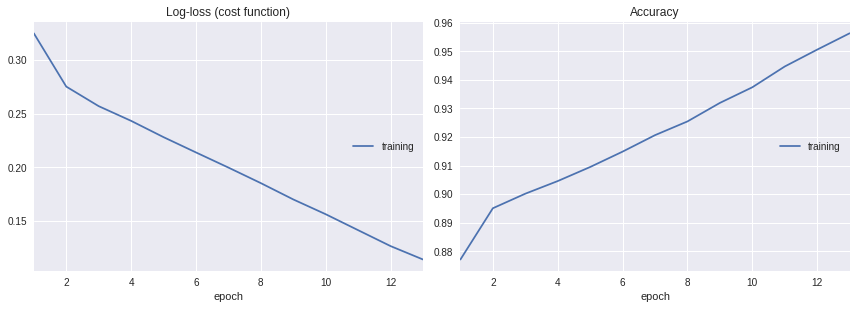

In [0]:
adam = optimizers.Adam(lr=0.0001)

movies_model.compile(optimizer=adam,
              loss='binary_crossentropy', metrics=['accuracy'], )

epochs = 13 #--2
batch_size = 32 

movies_model.fit([bottleneck_features_train, X_dtm_train1], [y_train_genres],
          epochs=epochs, batch_size=batch_size, callbacks=[PlotLossesKeras()],
          verbose=0)

Run the prediction with both TRAINING data, text and images


In [0]:
y_pred_test_genres = movies_model.predict([bottleneck_features_validation, X_dtm_test1])

In [0]:
#Calculate the AUC
roc_auc_score(y_test_genres, y_pred_test_genres, average='macro')


0.7220864919352527

Some result with other features
<br>
<table>
<tr>
<th>$features$</th>
<th>$AUC$</th>
</tr>
<tr>
<td> NN256, adam, categorical, 20 ep</td>
<td style="text-align:center"> 0.70300</td>
<td ></td>
</tr>
<tr>
<td>NN256,adam, categorical, 10 ep</td>
<td style="text-align:center">0.70249</td>
</tr>
<tr>
<td>NN256,adam, categorical, 40 ep</td>
<td style="text-align:center">0.68756</td>
</tr>
  <tr>
<td>NN256,adam, categorical, 25 ep</td>
<td style="text-align:center">0.68924</td>
</tr>
  <tr>
<td>NN128,adam, categorical, 15 ep</td>
<td style="text-align:center">0.69092</td>
</tr>
  <tr>
<td>NN256,adam, binary, 10 ep</td>
<td style="text-align:center">0.70366</td>
</tr>
  <tr>
<td>NN1024 128 24 </td>
<td style="text-align:center">0.68578</td>
</tr>
  <tr>
<td>NN sin dropout</td>
<td style="text-align:center">0.70600</td>
</tr>
  <tr>
<td>NN sin dropout 15 epch </td>
<td style="text-align:center">0.70397</td>
</tr>
  <tr>
<td>NN sin dropout 5 epch</td>
<td style="text-align:center"> 0.71100</td>
</tr>
  <tr>
<td>NNcomb 64 24</td>
<td style="text-align:center">0.68365</td>
</tr>
  <tr>
<td>NNcomb 64relu</td>
<td style="text-align:center">0.68513</td>
</tr>
  <tr>
<td>NN64softmax 0.5, drop 0.5, drop 0.7,  24</td>
<td style="text-align:center">0.69494</td>
</tr>
  <tr>
<td>NN254 drop 0.5  drop 0.8</td>
<td style="text-align:center">0.70457</td>
</tr>
  <tr>
<td>NN256 128 drop 0.95, 2 epoch</td>
<td style="text-align:center">0.72352</td>
</tr>
<tr>
<td> Video 1024 d 0.5 256, img 128 d0.8; 10 epch; batch 32</td>
<td style="text-align:center">0.73021</td>
</tr>
</table>

 

In [0]:
#Finally, Fit model with both TEST data, text and images
adam = optimizers.Adam(lr=0.0001)

movies_model.compile(optimizer=adam,
              loss='binary_crossentropy', metrics=['accuracy'])

epochs = 13
batch_size = 32

movies_model.fit([bottleneck_features_train2, X_dtm_train], [y_genres1],
          epochs=epochs, batch_size=batch_size, callbacks=[PlotLossesKeras()],
          verbose=0)

In [0]:
#then predict the model with both TEST data, text and images

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = movies_model.predict([bottleneck_features_validation2, X_dtm_test])

pd.DataFrame(y_pred_test_genres, index=texto_test.index, columns=cols).to_csv('pred_genres_textvideo_6.csv', index_label='ID')

In [0]:
#Upload resolts to KAGGLE
!kaggle competitions submit -c miia4406-movie-genre-classification -f pred_genres_textvideo_6.csv -m "DL TEXT AND VIDEO --- Video 1024 d 0.5 256, img 128 d0.8; 10 epch; batch 32 "

Successfully submitted to MIIA4406 - MOVIE GENRE CLASSIFICATION

In [0]:
#Download the csv results
from google.colab import files
files.download('pred_genres_textvideo_6.csv')